In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import ViTForImageClassification, ViTConfig, ViTImageProcessor, Trainer, TrainingArguments
from torchvision.transforms import v2
import torch.nn as nn

2025-12-11 12:24:56.426423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 12:24:56.457604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/cond

In [2]:
# Loading dataset
animal_dataset = load_dataset("imagefolder", data_dir="../../../data/animal_images")
animal_dataset

Resolving data files:   0%|          | 0/30000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2407 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2407
    })
})

In [3]:
# Checking example structure of dataset in training data
features = animal_dataset["train"].features
features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra'])}

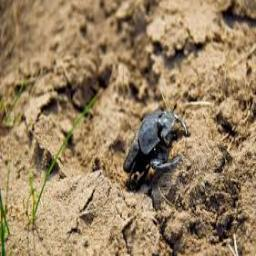

In [4]:
# Visualization of example content of dataset
animal_dataset['train'][10]['image']

In [5]:
# Splitting into seperate datasets to parse onto trainer later on
train_data = animal_dataset["train"]
validation_data = animal_dataset["validation"]
test_data = animal_dataset["test"]

In [6]:
# Label mapping for model (label-name -> index)
id2label = {id: label for id, label in enumerate(train_data.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_data[0]["label"]]

({0: 'Beetle',
  1: 'Butterfly',
  2: 'Cat',
  3: 'Cow',
  4: 'Dog',
  5: 'Elephant',
  6: 'Gorilla',
  7: 'Hippo',
  8: 'Lizard',
  9: 'Monkey',
  10: 'Mouse',
  11: 'Panda',
  12: 'Spider',
  13: 'Tiger',
  14: 'Zebra'},
 'Beetle')

In [7]:
# Loading processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224', do_rescale = False, return_tensors = 'pt')
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
from torchvision import transforms 

# Get configurations from ViT processor
size = processor.size.get("height", 224)
image_mean, image_std = processor.image_mean, processor.image_std

# Normalization and augmentation transformations
transformations = {
    "train": transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "validation": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "test": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
}


In [9]:
# Function to find the specified transformation configuration and apply it to the given example for 
def transform(examples, kind="train"):
    transform_fn = transformations.get(kind, transformations["train"])
    examples["pixel_values"] = [transform_fn(img.convert("RGB")) for img in examples["image"]]
    return examples
    
# Attaching right transformations to each dataset
train_data.set_transform(lambda examples: transform(examples, "train"))
validation_data.set_transform(lambda examples: transform(examples, "validation"))
test_data.set_transform(lambda examples: transform(examples, "test"))

In [10]:
import torch
from torch.utils.data import DataLoader

# Function fixes issue with data-types, as default trainer collate function is not aware how to stack the tensors from our dataset
def collate_fn(examples):
    # Stacks the pixel values of all examples into a single tensor and collects labels into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [11]:
# Loading model
from transformers import ViTForImageClassification, ViTConfig

labels = animal_dataset['train'].features['label'].names
BASE_MODEL_CONF = "google/vit-base-patch16-224"

PATCH_SIZE = 224

# Label mapping and patch size are defined in config
config = ViTConfig.from_pretrained(BASE_MODEL_CONF)
config.patch_size = PATCH_SIZE
config.num_labels = len(labels)
config.id2label = id2label
config.label2id = label2id

# Loading model with proper label mapping + configurable patch size
model = ViTForImageClassification.from_pretrained(
    BASE_MODEL_CONF,
    config=config,
    ignore_mismatched_sizes=True
)

# Defining Cross-Entropy-Loss as loss function
model.loss_fn = nn.CrossEntropyLoss()
model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 3, 224, 224]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(224, 224), stride=(224, 224))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

In [12]:
from transformers import TrainingArguments, Trainer
import numpy as np
from transformers import EarlyStoppingCallback

# Training params
TRAINING_STRATEGY = "fixed"
BATCH_SIZE = 32
EPOCHS = 5
STEPS = 200

output_dir = f"output_vit_patch_size{PATCH_SIZE}_automatic"

train_configs = {
    "prod": TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=BATCH_SIZE,
        eval_strategy="steps",
        save_steps=STEPS,
        eval_steps=STEPS,
        # warmup_steps=STEPS, 
        num_train_epochs=EPOCHS,
        fp16=True,
        logging_strategy="steps",
        logging_steps=STEPS,
        learning_rate=2e-4,
        lr_scheduler_type="cosine", # "linear" # "constant" 
        # optim="adamw_torch",
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_strategy="steps",
        save_total_limit=3,
        seed = 123
    ),

    "fixed": TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_steps=1,
        eval_steps=1,
        # warmup_steps=STEPS, 
        num_train_epochs=EPOCHS,
        fp16=True,
        logging_strategy="steps",
        logging_steps=STEPS,
        learning_rate=2e-4,
        # optim="adamw_torch",
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_strategy="epoch",
        save_total_limit=3,
        seed = 123
    ),

    "debug": TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=32,
        eval_strategy="steps",
        num_train_epochs=0.01,
        fp16=True,
        save_strategy="steps",
        save_steps=10,
        eval_steps=10,
        logging_strategy="steps",
        logging_steps=10,
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_total_limit=3,
        seed = 123
    ),
}

In [13]:
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix

# Load standard evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# Function called after completing eval strategy rule
def compute_metrics(eval_predictions):
    # Accessing model predictions
    model_calculations, true_labels = eval_predictions
    # Takes the model output with the highest value (so the most likely class to be predicted)
    model_predictions = np.argmax(model_calculations, axis=-1)

    """# Creating confusion matrix to check correctness of outputs (lines = true_labels, rows = model_predictions)
    confusion = confusion_matrix(true_labels, model_predictions)

    # Debug confusion info
    print(confusion.shape)
    print(confusion)

    # Manual calculations of result categories
    TP = np.diag(confusion).sum()
    FP = confusion.sum(axis=0) - np.diag(confusion)
    FN = confusion.sum(axis=1) - np.diag(confusion)
    TN = confusion.sum() - (FP + FN + np.diag(confusion)).sum()

    # Test verify accurracy
    acc = (TP + TN) / np.sum(confusion)
    print(f"Accurracy: {acc * 100:.2f}%") """
    
    # Computing all predefined metrics
    return {
        "accuracy": accuracy.compute(predictions=model_predictions, references=true_labels)["accuracy"],
        "precision": precision.compute(predictions=model_predictions, references=true_labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=model_predictions, references=true_labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=model_predictions, references=true_labels, average="weighted")["f1"],
    }

In [14]:
# Initializing and starting training
trainer = Trainer(
    model,
    train_configs.get(TRAINING_STRATEGY),
    train_dataset=train_data,
    eval_dataset=validation_data,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)],
)
trainer.train()

/tmp/ipykernel_6256/3669850515.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.583500,2.501685,0.164500,0.197703,0.164500,0.152154
2,2.516600,2.439350,0.194500,0.196188,0.194500,0.175189
3,2.488200,2.380450,0.223500,0.214326,0.223500,0.191276
4,2.473300,2.353292,0.242000,0.231056,0.242000,0.217862
5,2.453700,2.329597,0.248000,0.239031,0.248000,0.231058


TrainOutput(global_step=4690, training_loss=2.5141064967173756, metrics={'train_runtime': 728.6277, 'train_samples_per_second': 205.866, 'train_steps_per_second': 6.437, 'total_flos': 2.71866362729472e+19, 'train_loss': 2.5141064967173756, 'epoch': 5.0})

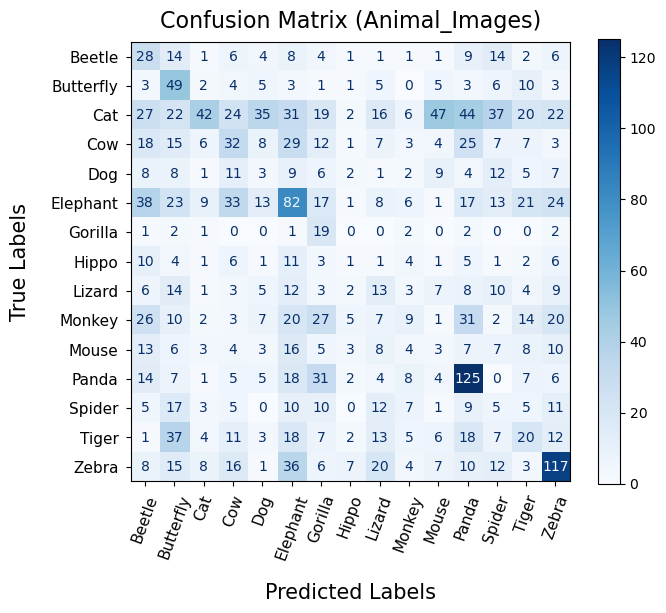



 scikit-learn report: 
              precision    recall  f1-score      support
Beetle         0.135922  0.280000  0.183007   100.000000
Butterfly      0.201646  0.490000  0.285714   100.000000
Cat            0.494118  0.106599  0.175365   394.000000
Cow            0.196319  0.180791  0.188235   177.000000
Dog            0.032258  0.034091  0.033149    88.000000
Elephant       0.269737  0.267974  0.268852   306.000000
Gorilla        0.111765  0.633333  0.190000    30.000000
Hippo          0.033333  0.017544  0.022989    57.000000
Lizard         0.112069  0.130000  0.120370   100.000000
Monkey         0.140625  0.048913  0.072581   184.000000
Mouse          0.030928  0.030000  0.030457   100.000000
Panda          0.394322  0.527426  0.451264   237.000000
Spider         0.037594  0.050000  0.042918   100.000000
Tiger          0.156250  0.121951  0.136986   164.000000
Zebra          0.453488  0.433333  0.443182   270.000000
accuracy       0.227669  0.227669  0.227669     0.227669
macro 

In [15]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Evaluation of model
predictions = trainer.predict(test_data)

# Ids of True Labels
labels_true = predictions.label_ids
# Ids of predicted labels
labels_pred = np.argmax(predictions.predictions, axis=-1)

# Configs for label <-> id mapping
id2label = model.config.id2label
label2id = model.config.label2id

# Plot of confusion matrix
result_confusion = confusion_matrix(labels_true, labels_pred)

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=result_confusion, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=70, values_format="d", ax=ax)

ax.set_xlabel("Predicted Labels", fontsize=15, labelpad=15)
ax.set_ylabel("True Labels", fontsize=15, labelpad=15)
ax.set_title("Confusion Matrix (Animal_Images)", fontsize=16, pad=10)

ax.tick_params(axis="x", labelsize=11, pad=5)
ax.tick_params(axis="y", labelsize=11, pad=5)
plt.tight_layout()

output_path = f"{output_dir}/confusion_matrix.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()


# Output of sklearn classification report
report = classification_report(
    labels_true,
    labels_pred,
    target_names=labels,
    output_dict=True,
)

report_df = pd.DataFrame(report).transpose()

print(f"\n\n scikit-learn report: \n{report_df}")

report_df.to_csv(f"{output_dir}/classification_report.csv", index=True)